### 과목 : 머신러닝

### 학번 : 2017250037

### 이름 : 이현수


1. 모델 기반 학습
    - 선형 회귀
1. 머신러닝의 주요 도전 과제
    - 대표성 없는 훈련 데이터
    - 과대적합과 모델 규제
1. 사례 기반 학습
    - k-최근접 이웃 회귀

In [1]:
# 파이썬 버전 ≥ 3.5
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn 버전 ≥0.20
import sklearn
assert sklearn.__version__ >= "0.20"

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [3]:
%matplotlib inline 

import matplotlib as mpl
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

## 모델 기반 학습

save_fig() 함수는 지정된 디렉토리에 생성된 도표를 저장하는 함수. 

In [4]:
import os

# 그래프 저장을 디렉토리 지정
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "fundamentals"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

# 그래프 저장 함수 선언
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

실행할 때 마다 동일한 결과가 나오도록 무작위 함수들의 시드(seed)를 지정.

In [5]:
import numpy as np

np.random.seed(42)

### 데이터 다운로드

책에 포함된 코드는 사용하는 데이터 파일이 주피터 노트북과 동일한 디렉토리에 위치한다고 가정한다. 여기서는 해당 데이터 파일를 notebooks/datasets/lifesat 디렉토리로 직접 다운로드하여 사용한다.

데이터 파일을 다운로드하기 전에 앞서 언급한 디렉토리의 경로를 지정한다.

In [6]:
datapath = os.path.join("notebooks", "datasets", "lifesat", "")

앞서 지정한 디렉토리로 데이터를 다운로드한다.
다운로드할 데이터는 교수님의 깃허브 리포지토리에 저장된
한 개의 csv 파일과 excel 파일이다.

* `oecd_bli_2020.csv`: 2020년도 기준 OECD의 더 나은 삶의 지수(BLI) 데이터 
* `gdp_per_capita_2020.xlsx`: IMF의 1인당 국내총생산 데이터(GDP) 데이터

In [7]:
import urllib.request
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/codingalzi/handson-ml/master/"
os.makedirs(datapath, exist_ok=True)
for filename in ("oecd_bli_2020.csv", "gdp_per_capita_2020.xlsx"):
    print("다운로드:", filename)
    url = DOWNLOAD_ROOT + "notebooks/datasets/lifesat/" + filename
    urllib.request.urlretrieve(url, datapath + filename)

다운로드: oecd_bli_2020.csv
다운로드: gdp_per_capita_2020.xlsx


### 삶의 만족도 데이터 적재와 준비

아래 코드는 OECD 에서 다운로드한 csv 파일에서 국가별 삶의 만족도 지수(BLI) 산출에 필요한 데이터만 데이터프레임 객체로 불러온다.
이런 과정을 __데이터 적재__(data loading)라 한다.
데이터 적재 후 필요한 데이터만 추출해서 선형 회귀 모델 훈련을 위해 데이터를 준비시킨다.
아래 코드는 `"INEQUALITY"` 특성이 `"TOT"`로 정해진 데이터만 가져온 후에
`pivot()` 메서드를 이용하여 국가별 삶의 만족도 정보만 데이터프레임으로 저장한다.


In [8]:
oecd_bli = pd.read_csv(datapath + "oecd_bli_2020.csv", thousands=',')
oecd_bli = oecd_bli[oecd_bli["INEQUALITY"]=="TOT"]
oecd_bli = oecd_bli.pivot(index="Country", columns="Indicator", values="Value")

# 알파벳 순으로 첫 5개 국가 데이터 보여주기
oecd_bli.head()

Indicator,Air pollution,Dwellings without basic facilities,Educational attainment,Employees working very long hours,Employment rate,Feeling safe walking alone at night,Homicide rate,Household net adjusted disposable income,Household net wealth,Housing expenditure,Labour market insecurity,Life expectancy,Life satisfaction,Long-term unemployment rate,Personal earnings,Quality of support network,Rooms per person,Self-reported health,Stakeholder engagement for developing regulations,Student skills,Time devoted to leisure and personal care,Voter turnout,Water quality,Years in education
Country,,,,,,,,,,,,,,,,,,,,,,,,
Australia,5.0,NaN,81.0,13.04,73.0,63.5,1.1,32759.0,427064.0,20.0,5.4,82.5,7.3,1.31,49126.0,95.0,NaN,85.0,2.7,502.0,14.35,91.0,93.0,21.0
Austria,16.0,0.9,85.0,6.66,72.0,80.6,0.5,33541.0,308325.0,21.0,3.5,81.7,7.1,1.84,50349.0,92.0,1.6,70.0,1.3,492.0,14.55,80.0,92.0,17.0
Belgium,15.0,1.9,77.0,4.75,63.0,70.1,1.0,30364.0,386006.0,21.0,3.7,81.5,6.9,3.54,49675.0,91.0,2.2,74.0,2.0,503.0,15.70,89.0,84.0,19.3
Brazil,10.0,6.7,49.0,7.13,61.0,35.6,26.7,NaN,NaN,NaN,NaN,74.8,6.4,NaN,NaN,90.0,NaN,NaN,2.2,395.0,NaN,79.0,73.0,16.2
Canada,7.0,0.2,91.0,3.69,73.0,82.2,1.3,30854.0,423849.0,22.0,6.0,81.9,7.4,0.77,47622.0,93.0,2.6,88.0,2.9,523.0,14.56,68.0,91.0,17.3


알파벳 순으로 첫 5개 국가의 삶의 만족도(BLI)는 `"Life satisfaction"` 컬럼(column)에서 확인할 수 있다.

In [9]:
oecd_bli["Life satisfaction"].head()

Country
Australia    7.3
Austria      7.1
Belgium      6.9
Brazil       6.4
Canada       7.4
Name: Life satisfaction, dtype: float64

### 1인당 GDP 데이터 적재와 준비

아래 코드는 IMF 에서 다운로드한 excel 파일에서 2020년 기준 국가별 1인당 GDP 관련 데이터를 데이터프레임 객체로 불러온다.

In [10]:
gdp_per_capita = pd.read_excel(datapath+"gdp_per_capita_2020.xlsx", thousands=',', na_values="n/a") # delimiter 과 encoding 파라미터 x
gdp_per_capita.rename(columns={2020: "GDP per capita"}, inplace=True) # 2020 컬럼 이름을 "GDP per capita" 로 변경 
gdp_per_capita.set_index("Country", inplace=True)

# 알파벳 순으로 첫 5개 국가 GDP 정보 확인
gdp_per_capita.head()

,Subject Descriptor,Units,Scale,Country/Series-specific Notes,GDP per capita,Estimates Start After
Country,,,,,,
Afghanistan,"Gross domestic product per capita, current prices",U.S. dollars,Units,"See notes for: Gross domestic product, curren...",499.441,2019.0
Albania,"Gross domestic product per capita, current prices",U.S. dollars,Units,"See notes for: Gross domestic product, curren...",4898.277,2018.0
Algeria,"Gross domestic product per capita, current prices",U.S. dollars,Units,"See notes for: Gross domestic product, curren...",3331.076,2019.0
Angola,"Gross domestic product per capita, current prices",U.S. dollars,Units,"See notes for: Gross domestic product, curren...",2021.310,2017.0
Antigua and Barbuda,"Gross domestic product per capita, current prices",U.S. dollars,Units,"See notes for: Gross domestic product, curren...",14158.571,2011.0


### 데이터 병합

두 데이터를 하나의 데이터프레임으로 병합한다.
삶의 지수 데이터를 왼편에, 1인당 GDP 데이터를 오른편에 위치시키며 기준은 국가명이다.

In [11]:
full_country_stats = pd.merge(left=oecd_bli, right=gdp_per_capita, left_index=True, right_index=True)

또한 1인당 GDP 기준으로 오름차순으로 국가를 정렬시킨다.

In [12]:
full_country_stats.sort_values(by="GDP per capita", inplace=True) # 1인당 GDP 기준으로 정렬

1인당 GDP 기준 하위 3개 국가는 남아프리카, 콜럼비아, 브라질이다.

In [13]:
full_country_stats.head(3)

,Air pollution,Dwellings without basic facilities,Educational attainment,Employees working very long hours,Employment rate,Feeling safe walking alone at night,Homicide rate,Household net adjusted disposable income,Household net wealth,Housing expenditure,Labour market insecurity,Life expectancy,Life satisfaction,Long-term unemployment rate,Personal earnings,Quality of support network,Rooms per person,Self-reported health,Stakeholder engagement for developing regulations,Student skills,Time devoted to leisure and personal care,Voter turnout,Water quality,Years in education,Subject Descriptor,Units,Scale,Country/Series-specific Notes,GDP per capita,Estimates Start After
Country,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
South Africa,22.0,37.0,73.0,18.12,43.0,36.1,13.7,NaN,NaN,18.0,NaN,57.5,4.7,16.46,NaN,88.0,NaN,NaN,NaN,NaN,14.92,73.0,67.0,NaN,"Gross domestic product per capita, current prices",U.S. dollars,Units,"See notes for: Gross domestic product, curren...",4735.747,2019.0
Colombia,10.0,23.9,54.0,26.56,67.0,44.4,24.5,NaN,NaN,17.0,NaN,76.2,6.3,0.79,NaN,89.0,1.2,NaN,1.4,410.0,NaN,53.0,75.0,14.1,"Gross domestic product per capita, current prices",U.S. dollars,Units,"See notes for: Gross domestic product, curren...",5207.238,2019.0
Brazil,10.0,6.7,49.0,7.13,61.0,35.6,26.7,NaN,NaN,NaN,NaN,74.8,6.4,NaN,NaN,90.0,NaN,NaN,2.2,395.0,NaN,79.0,73.0,16.2,"Gross domestic product per capita, current prices",U.S. dollars,Units,"See notes for: Gross domestic product, curren...",6450.451,2019.0


1인당 GDP 기준 상위 3개 룩셈부르크, 스위스, 아일랜드 이다.



In [14]:
full_country_stats.tail(3)

,Air pollution,Dwellings without basic facilities,Educational attainment,Employees working very long hours,Employment rate,Feeling safe walking alone at night,Homicide rate,Household net adjusted disposable income,Household net wealth,Housing expenditure,Labour market insecurity,Life expectancy,Life satisfaction,Long-term unemployment rate,Personal earnings,Quality of support network,Rooms per person,Self-reported health,Stakeholder engagement for developing regulations,Student skills,Time devoted to leisure and personal care,Voter turnout,Water quality,Years in education,Subject Descriptor,Units,Scale,Country/Series-specific Notes,GDP per capita,Estimates Start After
Country,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Ireland,7.0,1.0,82.0,5.25,67.0,75.9,0.7,25310.0,217130.0,20.0,7.8,81.8,7.0,3.23,47653.0,95.0,2.1,83.0,1.3,509.0,NaN,65.0,85.0,18.1,"Gross domestic product per capita, current prices",U.S. dollars,Units,"See notes for: Gross domestic product, curren...",79668.502,2019.0
Switzerland,15.0,0.1,88.0,0.37,80.0,85.3,0.6,37466.0,NaN,22.0,NaN,83.7,7.5,1.82,62283.0,93.0,1.9,78.0,2.3,506.0,NaN,49.0,95.0,17.5,"Gross domestic product per capita, current prices",U.S. dollars,Units,"See notes for: Gross domestic product, curren...",81867.462,2019.0
Luxembourg,12.0,0.5,77.0,3.82,66.0,75.8,0.6,39264.0,769053.0,21.0,1.7,82.8,6.9,2.35,63062.0,93.0,1.9,69.0,1.7,483.0,NaN,91.0,84.0,15.1,"Gross domestic product per capita, current prices",U.S. dollars,Units,"See notes for: Gross domestic product, curren...",109602.322,2018.0


아래 코드는 잠시 뒤에 선형회귀 모델의 적합도를 설명하기 위해 고의로 7개의 국가의 데이터를 데이터셋에서 제외킨다.

In [15]:
# 7개 국가의 행 인덱스를 전체 인덱스 집합에서 제거
remove_indices = [1, 2, 4, 6, 37, 38, 39]
keep_indices = list(set(range(40)) - set(remove_indices))

# 7개 국가를 제외한 국가들의 1인당 GDP와 삶의 만족도 데이터
sample_data = full_country_stats[["GDP per capita", 'Life satisfaction']].iloc[keep_indices] 

# 제외된 7개 국가의 1인당 GGP와 삶의 만족도 데이터
missing_data = full_country_stats[["GDP per capita", 'Life satisfaction']].iloc[remove_indices]

제외된 7개 국가의 데이터를 제외한 국가들의 1인당 GDP와 삶의 만족도 사이의 관계를 산점도로 나타낸다.
다만 아래에 언급된 5개 국가는 빨간색 점으로 표시된다.

* 헝가리(Hungary)
* 대한민국(Korea)
* 프랑스(France)
* 호주(Australia)
* 미국(United States)

Saving figure money_happy_scatterplot


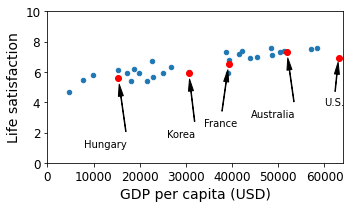

In [16]:
# 7개 국가를 제외한 국가들의 데이터 산점도
sample_data.plot(kind='scatter', x="GDP per capita", y='Life satisfaction', figsize=(5,3))
plt.axis([0, 64000, 0, 10])

# 언급된 5개 국가명 명기 좌표
position_text = {
  "Hungary": (8000, 1),
  "Korea": (26000, 1.7),
  "France": (34000, 2.4),
  "Australia": (44000, 3.0),
  "United States": (60000, 3.8),
}

# 5개 국가는 좌표를 이용하여 빨강색 점으로 표기
for country, pos_text in position_text.items():
    pos_data_x, pos_data_y = sample_data.loc[country]
    # 5개 국가명 표기
    country = "U.S." if country == "United States" else country
    plt.annotate(country, xy=(pos_data_x, pos_data_y), xytext=pos_text,
            arrowprops=dict(facecolor='black', width=0.5, shrink=0.1, headwidth=5))
    # 5개 국가 산점도 그리기
    plt.plot(pos_data_x, pos_data_y, "ro")
plt.xlabel("GDP per capita (USD)")
save_fig('money_happy_scatterplot')
plt.show()

언급된 5개 국가의 1인당 GDP와 삶의 만족도를 데이터에서 직접 확인하면 다음과 같다.

In [17]:
sample_data.loc[list(position_text.keys())]

,GDP per capita,Life satisfaction
Country,,
Hungary,15372.885,5.6
Korea,30644.427,5.9
France,39257.434,6.5
Australia,51885.466,7.3
United States,63051.398,6.9


### 선형 관계

위 산점도에 따르면 1인당 GDP와 삶의 만족도가 어느 정도 선형 관계에 있는 것처럼 보인다.
아래 도표에서 그려진 세 개의 직선 중에서 그나마 파랑색 실선이 선형 관계를 가장 적절하게 나타낸다.

Saving figure tweaking_model_params_plot


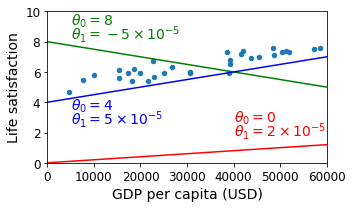

In [18]:
import numpy as np

sample_data.plot(kind='scatter', x="GDP per capita", y='Life satisfaction', figsize=(5,3))
plt.xlabel("GDP per capita (USD)")
plt.axis([0, 60000, 0, 10])
X=np.linspace(0, 60000, 1000)
plt.plot(X, 2*X/100000, "r")
plt.text(40000, 2.7, r"$\theta_0 = 0$", fontsize=14, color="r")
plt.text(40000, 1.8, r"$\theta_1 = 2 \times 10^{-5}$", fontsize=14, color="r")
plt.plot(X, 8 - 5*X/100000, "g")
plt.text(5000, 9.1, r"$\theta_0 = 8$", fontsize=14, color="g")
plt.text(5000, 8.2, r"$\theta_1 = -5 \times 10^{-5}$", fontsize=14, color="g")
plt.plot(X, 4 + 5*X/100000, "b")
plt.text(5000, 3.5, r"$\theta_0 = 4$", fontsize=14, color="b")
plt.text(5000, 2.6, r"$\theta_1 = 5 \times 10^{-5}$", fontsize=14, color="b")
save_fig('tweaking_model_params_plot')
plt.show()

### &#x1f511;  선형회귀 모델 훈련

선형 관계는 위 도표에서처럼 직선으로 구현되는 __선형회귀 모델__(linear regression model)은 
직선의 절편(Y축과 만나는 점)과 기울기 두 개의 __모델 파라미터__(model parameters)에 의해 결정된다.
예를 들어, 1인당 GDP와 삶의 만족도는 아래 선형 모델로 표현할 수 있다.

$$
\text{삶의만족도} = \theta_0 + \theta_1 \times \text{1인당GDP}
$$

아래 코드는 최적의 선형 모델의 절편과 기울기를 알아내는 모델의 생성과 훈련과정을 나타낸다.

* 모델 지정: 사이킷런(sklearn) 패키지의 `linear_model` 모듈에 포함된 `LinearRegression` 클래스 활용
* 훈련 데이터넷 지정
    * 특성 데이터: 1인당 GDP
    * 타깃 데이터: 삶의 만족도
* 모델 훈련: `fit()` 메서드 호출
    * 반환값: 훈련된 선형회귀 모델

In [19]:
from sklearn import linear_model

# 선형회귀 모델 지정
lin1 = linear_model.LinearRegression()

# 훈련 데이터셋 지정
Xsample = np.c_[sample_data["GDP per capita"]]
ysample = np.c_[sample_data["Life satisfaction"]]

# 모델 훈련
lin1.fit(Xsample, ysample)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

훈련된 모델이 알아낸 최적 선형 모델의 절편과 기울기는 아래 두 속성에 저장된다.

* `intercept_[0]`: 직선의 절편
* `coef_[0]`: 직선의 기울기

In [20]:
# 예측된 최적의 직선에 대한 정보: 절편과 기울기
t0, t1 = lin1.intercept_[0], lin1.coef_[0][0]

t0, t1

(5.071121853750363, 4.1410177424136694e-05)

구해진 기울기와 절편을 이용하여 산점도와 함께 직선을 그리면 다음과 같다.

Saving figure best_fit_model_plot


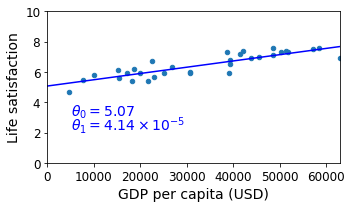

In [21]:
# 산점도
sample_data.plot(kind='scatter', x="GDP per capita", y='Life satisfaction', figsize=(5,3))
plt.xlabel("GDP per capita (USD)")
plt.axis([0, 63000, 0, 10])

# 직선 그리기
X=np.linspace(0, 63000, 1000)
plt.plot(X, t0 + t1*X, "b")
# 직선의 절편과 기울기 정보 명시
plt.text(5000, 3.1, r"$\theta_0 = 5.07$", fontsize=14, color="b")
plt.text(5000, 2.2, r"$\theta_1 = 4.14 \times 10^{-5}$", fontsize=14, color="b")

save_fig('best_fit_model_plot')
plt.show()

### &#x1f511;  훈련된 모델 활용

훈련된 모델을 이용하여 한 국가의 삶의 만족도를 1인당 GDP를 이용하여 예측한다. 
예를 들어, 키프러스(Cyprus) 1인당 GDP만 다음과 같이 알려져 있을 때 키프러스 국민의 삶의 만족도를 예측한다.

* 키프러스 1인당 GDP: 26240

In [22]:
cyprus_gdp_per_capita = gdp_per_capita.loc["Cyprus"]["GDP per capita"]
print(cyprus_gdp_per_capita)

26240.048


훈련된 모델의 `predict()` 메서드를 이용하면 키프러스 국민의 삶의 만족도는 6.15 정도로 예측된다.

In [23]:
cyprus_predicted_life_satisfaction = lin1.predict([[cyprus_gdp_per_capita]])[0][0]
cyprus_predicted_life_satisfaction

6.157726897048226

아래 도표에서 확인할 수 있듯이 예측값은 정확하게 앞서 확인한 최적의 직선 위에 위치한다.

Saving figure cyprus_prediction_plot


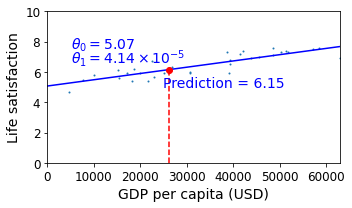

In [24]:
sample_data.plot(kind='scatter', x="GDP per capita", y='Life satisfaction', figsize=(5,3), s=1)
plt.xlabel("GDP per capita (USD)")

# 예측된 최적의 직선
X=np.linspace(0, 63000, 1000)
plt.plot(X, t0 + t1*X, "b")
plt.axis([0, 63000, 0, 10])
plt.text(5000, 7.5, r"$\theta_0 = 5.07$", fontsize=14, color="b")
plt.text(5000, 6.6, r"$\theta_1 = 4.14 \times 10^{-5}$", fontsize=14, color="b")

# 키프러스에 대한 삶의 만족도 예측값

# 빨간 점선 그리기
plt.plot([cyprus_gdp_per_capita, cyprus_gdp_per_capita], [0, cyprus_predicted_life_satisfaction], "r--")
plt.text(25000, 5.0, r"Prediction = 6.15", fontsize=14, color="b")

# 예측 지점 좌표 찍기(빨강생)
plt.plot(cyprus_gdp_per_capita, cyprus_predicted_life_satisfaction, "ro")
save_fig('cyprus_prediction_plot')
plt.show()

## 머신러닝의 주요 도전 과제

### 대표성 없는 훈련 데이터

앞서 7개 국가의 데이터를 훈련에서 제외시킨 후에 선형회귀 모델을 훈련시켰다.
이제 7개 국가를 포함해서 훈련시켜 보자.
제외된 7개 국가의 데이터는 다음과 같다.

* Columbia(콜롬비아) 
* Brazil(브라질)
* Mexico(멕시코)
* Chille(칠레)
* Ireland(아일랜드)
* Switzerland(스위스)
* Luxembourg(룩셈부르크)

In [25]:
missing_data

,GDP per capita,Life satisfaction
Country,,
Colombia,5207.238,6.3
Brazil,6450.451,6.4
Mexico,8069.104,6.5
Chile,12612.322,6.5
Ireland,79668.502,7.0
Switzerland,81867.462,7.5
Luxembourg,109602.322,6.9


아래 좌표는 7개 국가명을 아래 도표에서 표기할 때 사용할 좌표이다

In [26]:
position_text2 = {
    "Colombia": (5200, 6.3),
    "Brazil": (6450, 6.4),
    "Mexico": (8070, 6.5),
    "Chile": (12600, 6.5),
    "Ireland": (80000, 7.0),
    "Switzerland": (82000, 7.5),
    "Luxembourg": (110000, 6.9),
}

7개 국가를 포함한 전체 훈련 데이터셋을 이용하여 훈련한 결과를
7개 국가를 제외했을 때의 훈련 결과와 비교한다.

* 검정 실선: 7개 국가 포함 예측 선형 모델
* 파랑 점선: 7개 국가 제외 예측 선형 모델

__결론:__ 선형회귀 모델은 1인당 GDP와 삶의 만족도 사이의 관계를 모델링 하기에 부적합하다.

Saving figure representative_training_data_scatterplot


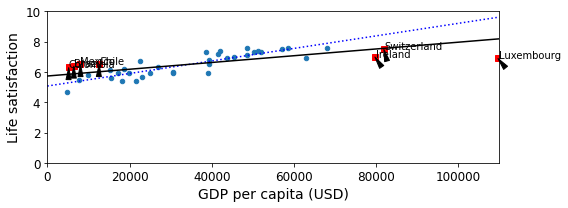

In [27]:
# 7개 국가를 제외한 국가들의 산점도 (파랑색 점)
sample_data.plot(kind='scatter', x="GDP per capita", y='Life satisfaction', figsize=(8,3))
plt.axis([0, 110000, 0, 10])

# 7개 국가 산점도(빨강 점)
for country, pos_text in position_text2.items():
    pos_data_x, pos_data_y = missing_data.loc[country]
    # 7개 국가명 표기
    plt.annotate(country, xy=(pos_data_x, pos_data_y), xytext=pos_text,
            arrowprops=dict(facecolor='black', width=0.5, shrink=0.1, headwidth=5))
    plt.plot(pos_data_x, pos_data_y, "rs")

# 7개 국가 제외 예측 선형 모델 그래프 (파랑 점선)
X=np.linspace(0, 110000, 1000)
plt.plot(X, t0 + t1*X, "b:")

# 7개 국가 포함 선형회귀 모델 훈련 및 예측
lin_reg_full = linear_model.LinearRegression()
Xfull = np.c_[full_country_stats["GDP per capita"]]
yfull = np.c_[full_country_stats["Life satisfaction"]]
lin_reg_full.fit(Xfull, yfull)

# 7개 국가 포함 예측 선형 모델 그래프(검정 실선)
t0full, t1full = lin_reg_full.intercept_[0], lin_reg_full.coef_[0][0]
X = np.linspace(0, 110000, 1000)
plt.plot(X, t0full + t1full * X, "k")
plt.xlabel("GDP per capita (USD)")

save_fig('representative_training_data_scatterplot')
plt.show()

### 과대적합과 모델 규제

#### 과대적합

훈련된 모델이 훈련데이터에는 너무나도 잘 맞지만 새로운 데이터에 대해서는 잘 작동하지 않을 때 해당 모델이 훈련데이터에 __과대적합__되었다고 말한다.

예를 들어, 
아래 코드는 4장에서 다룰 고차항 다항회귀를 이용하여 선형이 아니라 60차 다항식의 그래프로 모델을 예측한다.
결과는 훈련데이터셋에 매우 잘 들어맞지만, 새로운 데이터에 대해 훈련된 모델이 제대로된 예측을 할 수 있을 
거라고 믿기는 어렵다. 이런 모델은 __일반화가 어렵다__라고 말한다.

__주의사항:__ 아래 코드를 지금 당장 이해하려고 시도할 필요는 없다.

/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1544: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Saving figure overfitting_model_plot


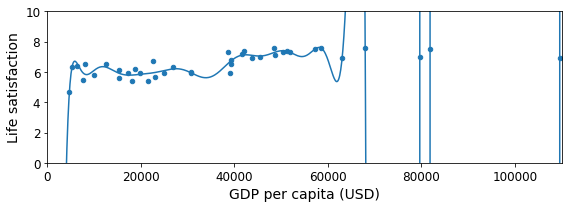

In [28]:
full_country_stats.plot(kind='scatter', x="GDP per capita", y='Life satisfaction', figsize=(8,3))
plt.axis([0, 110000, 0, 10])

from sklearn import preprocessing
from sklearn import pipeline

poly = preprocessing.PolynomialFeatures(degree=60, include_bias=False)
scaler = preprocessing.StandardScaler()
lin_reg2 = linear_model.LinearRegression()

pipeline_reg = pipeline.Pipeline([('poly', poly), ('scal', scaler), ('lin', lin_reg2)])
pipeline_reg.fit(Xfull, yfull)
curve = pipeline_reg.predict(X[:, np.newaxis])
plt.plot(X, curve)
plt.xlabel("GDP per capita (USD)")
save_fig('overfitting_model_plot')
plt.show()

훈련세트에 잡음이 많이 있거나 데이터셋이 너무 작으면 훈련 과정에서 별로 상관 없는 특성을 이용하려고 시도할 수도 있다. 
예를 들어, 아래 코드에서 확인할 수 있듯이 OECD에 속하는 국가 중에서 나라 이름에 영어 알파벳 W가 포함된 아래의 나라의 삶의 만족도가 매우 높은 편이다.

In [29]:
full_country_stats.loc[[c for c in full_country_stats.index if "W" in c.upper()]]["Life satisfaction"]

Country
New Zealand    7.3
Sweden         7.3
Norway         7.6
Switzerland    7.5
Name: Life satisfaction, dtype: float64

하지만 그렇다해서 나라명에 영어 알파벳 W가 포함된 모든 나라의 삶의 만족도가 높다고 결론 지을 수는 없다.
실제로 영어 알파벳 W를 포함한 국가 중에 여러 국가의 1인당 GDP가 아래 코드에서 볼 수 있듯이 매우 낮은데,
예를 들어, 루완다(Rwanda), 짐바브웨(Zimbabwe) 등의 국가의 삶의 만족도를 그럼에도 불구하고 매우 높다고 말할 수는 없다.

In [30]:
gdp_per_capita.sort_values(by="GDP per capita", inplace=True) # 1인당 GDP 기준으로 정렬

In [31]:
gdp_per_capita.loc[[c for c in gdp_per_capita.index if 'w' in str(c).lower()]].head()

,Subject Descriptor,Units,Scale,Country/Series-specific Notes,GDP per capita,Estimates Start After
Country,,,,,,
Malawi,"Gross domestic product per capita, current prices",U.S. dollars,Units,"See notes for: Gross domestic product, curren...",399.097,2011.0
Rwanda,"Gross domestic product per capita, current prices",U.S. dollars,Units,"See notes for: Gross domestic product, curren...",823.402,2012.0
Zimbabwe,"Gross domestic product per capita, current prices",U.S. dollars,Units,"See notes for: Gross domestic product, curren...",921.847,2017.0
Papua New Guinea,"Gross domestic product per capita, current prices",U.S. dollars,Units,"See notes for: Gross domestic product, curren...",2651.519,2014.0
West Bank and Gaza,"Gross domestic product per capita, current prices",U.S. dollars,Units,"See notes for: Gross domestic product, curren...",2894.069,2019.0


#### 모델 규제

4장에서 다루는 '규제가 있는 선형 모델'에서 다루는 이용하면 과대적합의 위험을 줄일 수 있다.
이렇게 과대적합의 위험을 감소시키기 위에 훈련 모델에 제약을 가하는 것을 __규제__(regularization)라고 한다.

아래 코드는 세 개의 모델을 비교한다.

* 빨강 파선: 7개 국가 포함 예측 선형 모델
* 파랑 점선: 7개 국가 제외 예측 선형 모델
* 파랑 실선: 7개 국가 제외 규제 적용 예측 선형 모델
    * 규제 방식: Ridge 규제(4장 참조)

7개 국가를 제외하더라도 모델에 규제를 적용하면 데이터에 덜 과대적합한 모델을 얻게 됨을 
세 개의 그래프를 비교해서 알 수 있다.

Saving figure ridge_model_plot


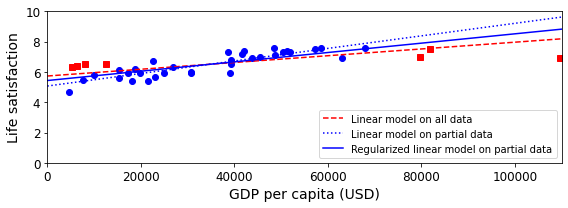

In [32]:
plt.figure(figsize=(8,3))

plt.xlabel("GDP per capita")
plt.ylabel('Life satisfaction')

# 7개 국가 제외 데이터 산점도(파랑 동그라미)
plt.plot(list(sample_data["GDP per capita"]), list(sample_data["Life satisfaction"]), "bo")
# 제외된 7개 국가 산점도(빨강 네모)
plt.plot(list(missing_data["GDP per capita"]), list(missing_data["Life satisfaction"]), "rs")

# 7개 국가 포함 예측 선형 모델 그래프(빨강 파선)
X = np.linspace(0, 110000, 1000)
plt.plot(X, t0full + t1full * X, "r--", label="Linear model on all data")
# 7개 국가 제외 예측 선형 모델 그래프(파랑 점선)
plt.plot(X, t0 + t1*X, "b:", label="Linear model on partial data")

# 릿지(Ridge) 규제 적용 훈련: 7개 국가 제외 데이터 대상
ridge = linear_model.Ridge(alpha=10**9.5)
Xsample = np.c_[sample_data["GDP per capita"]]
ysample = np.c_[sample_data["Life satisfaction"]]
ridge.fit(Xsample, ysample)
# 릿지 규제 적용 예측 선형 모델 그래프(파랑 실선)
t0ridge, t1ridge = ridge.intercept_[0], ridge.coef_[0][0]
plt.plot(X, t0ridge + t1ridge * X, "b", label="Regularized linear model on partial data")

plt.legend(loc="lower right")
plt.axis([0, 110000, 0, 10])
plt.xlabel("GDP per capita (USD)")
save_fig('ridge_model_plot')
plt.show()

## 사례 기반 학습

키프러스의 삶의 만족도를 사례 기반 학습으로 예측하기 위해
1인당 GDP가 키프러스의 경우가 가장 가까운 국가들의 삶의 만족도의 평균값을 활용할 수 있다.

예를 들어, 키프러스의 1인당 GDP와 가장 가까운 세 나라는 다음과 같다.

* Estonia
* Slovenia
* Spain

In [33]:
sample_data[11:14]

,GDP per capita,Life satisfaction
Country,,
Estonia,22985.858,5.7
Slovenia,25038.792,5.9
Spain,26831.629,6.3


위 세 나라의 삶의 만족도의 평균값은 다음과 같다.

In [34]:
(5.7+5.9+6.3) / 3

5.966666666666668

앞서 설명한 알고리즘을 __k-최근접 이웃__ 회귀라고 하며,
위 예제에서 사용된 k는 3이다. 

사이킷런에서 지원하는 k-최근접 이웃 회귀모델을 적용하면 동일한 결과를 얻게 된다.

* `n_neighbors = 3`: 예측할 데이터와 가장 가까운 3개의 훈련 데이터 정보를 활용한다는 의미임.

In [35]:
import sklearn.neighbors
model = sklearn.neighbors.KNeighborsRegressor(n_neighbors=3)

In [36]:
X = np.c_[sample_data["GDP per capita"]]
y = np.c_[sample_data["Life satisfaction"]]

# 모델 훈련
model.fit(X, y)

# 키프러스 국가에 대한 예측하기
X_new = np.array([[26240.0]])  # Cyprus' GDP per capita
print(model.predict(X_new)) # outputs [[ 5.96666667]]

[[5.96666667]]
